# <center>RFM 지표를 사용한 고객 세분화와 집단별 마케팅 제안</center>

## Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

## Read Data

In [2]:
# 고객 멤버십 정보 데이터 읽기
demo = pd.read_csv('data/Demo.csv', encoding='cp949')

# 구매 데이터 읽기
purchase = pd.read_csv('data/구매내역정보.csv', encoding='cp949')
purchase['구매일자'] = pd.to_datetime(purchase['구매일자'].astype(str)+purchase['구매시간'].astype(str).str.zfill(2), 
                                      format='%Y%m%d%H')

In [3]:
data = demo.merge(purchase, on='ID')
print('데이터 크기:', data.shape)

데이터 크기: (101692, 12)


## EDA
- 매장별 상품대분류명을 보면 명품 외 4개 상품대분류를 판매하는 지점과 가전제품과 생활잡화만 판매하는 지점이 있음을 알 수 있다.<br>
  롯데 계열사 데이터로 롯데백화점과 롯데 하이마트 데이터임을 유추할 수 있다.

In [4]:
data.groupby('구매지역')['상품대분류명'].unique()

구매지역
경기 고양시     [가전제품, 식품, 의류잡화, 생활잡화, 가구, 레포츠, 명품]
경기 광명시     [의류잡화, 가전제품, 식품, 레포츠, 생활잡화, 가구, 명품]
경기 광주시                                  [가전제품]
경기 구리시     [의류잡화, 가전제품, 생활잡화, 식품, 레포츠, 가구, 명품]
경기 군포시                                  [가전제품]
                          ...                 
서울 영등포구    [식품, 가전제품, 생활잡화, 의류잡화, 레포츠, 명품, 가구]
서울 용산구                            [가전제품, 생활잡화]
서울 은평구                            [가전제품, 생활잡화]
서울 중구      [가전제품, 생활잡화, 식품, 의류잡화, 레포츠, 명품, 가구]
서울 중랑구                                  [가전제품]
Name: 상품대분류명, Length: 65, dtype: object

In [5]:
data.loc[data.구매지역.str.contains('서울')].groupby('구매지역')['상품대분류명'].unique()

구매지역
서울 강남구     [식품, 생활잡화, 가전제품, 의류잡화, 레포츠, 가구, 명품]
서울 강동구                            [가전제품, 생활잡화]
서울 강북구     [식품, 의류잡화, 명품, 생활잡화, 레포츠, 가전제품, 가구]
서울 강서구         [식품, 의류잡화, 레포츠, 가전제품, 생활잡화, 가구]
서울 관악구     [식품, 생활잡화, 가구, 가전제품, 의류잡화, 레포츠, 명품]
서울 광진구         [식품, 생활잡화, 가전제품, 의류잡화, 레포츠, 명품]
서울 구로구                            [가전제품, 생활잡화]
서울 금천구                                  [가전제품]
서울 노원구     [식품, 생활잡화, 레포츠, 의류잡화, 가구, 가전제품, 명품]
서울 도봉구                            [가전제품, 생활잡화]
서울 동대문구    [가전제품, 의류잡화, 식품, 생활잡화, 레포츠, 명품, 가구]
서울 동작구                            [가전제품, 생활잡화]
서울 마포구                            [가전제품, 생활잡화]
서울 서대문구                                 [가전제품]
서울 서초구                                  [가전제품]
서울 성동구                                  [가전제품]
서울 성북구                                  [가전제품]
서울 송파구     [가전제품, 생활잡화, 의류잡화, 식품, 명품, 레포츠, 가구]
서울 양천구                            [가전제품, 생활잡화]
서울 영등포구    [식품, 가전제품, 생활잡화, 의류잡화, 레포츠, 명품, 가구]
서울 용산구                            [가전제품, 생활잡화]
서울 은평구  

- 구매금액이 0인 데이터를 확인하였다. <br>
  구매금액이 0인 데이터 중 환불데이터를 분석해 환불 시 같은 거래에서 구매한 타상품과 같이 환불함을 확인해 행사 상품이라 유추한다.

In [6]:
data.query('구매금액 == 0').shape

(202, 12)

In [7]:
display(data.query('ID==351800310 and 구매일자 <= "2014-08-10 15:00:00"').sort_values(['구매일자','구매수량'], ascending=[True, False]))

,ID,성별,연령,거주지역,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부
9094,351800310,2,67,부산 연제구,레포츠,스포츠용품/의류,부산 부산진구,2014-01-02 15:00:00,15,175,156000,0
9081,351800310,2,67,부산 연제구,레포츠,스포츠용품/의류,부산 부산진구,2014-01-03 11:00:00,11,-175,-155000,1
9084,351800310,2,67,부산 연제구,레포츠,스포츠용품/의류,부산 부산진구,2014-01-03 12:00:00,12,1,150000,0
9087,351800310,2,67,부산 연제구,레포츠,스포츠용품/의류,부산 부산진구,2014-01-03 13:00:00,13,1,169000,0
9090,351800310,2,67,부산 연제구,식품,가공식품,부산 부산진구,2014-01-03 13:00:00,13,1,21000,0
9083,351800310,2,67,부산 연제구,생활잡화,생활용품,부산 부산진구,2014-02-05 11:00:00,11,1,13000,0
9082,351800310,2,67,부산 연제구,레포츠,스포츠용품/의류,부산 부산진구,2014-07-25 11:00:00,11,36,32000,0
9092,351800310,2,67,부산 연제구,레포츠,스포츠용품/의류,부산 부산진구,2014-07-25 14:00:00,14,-36,-32000,1
9107,351800310,2,67,부산 연제구,레포츠,스포츠용품/의류,부산 부산진구,2014-07-25 17:00:00,17,1,39000,0
9086,351800310,2,67,부산 연제구,레포츠,스포츠용품/의류,부산 부산진구,2014-08-06 12:00:00,12,97,86000,0


In [8]:
# 증정상품의 취소일, 시간, 수량 추출
for _, ID, RDATE, COUNT in data.query('구매금액 == 0 and 취소여부 == 1')[['ID','구매일자','구매수량']].itertuples():
    # 취소한 행사상품, 수량, 금액 추출
    event_set = data.query('ID == @ID and 구매일자 == @RDATE and 구매수량 < 0')[['상품중분류명','구매수량','구매금액']]
    # 취소한 행사상품의 구매일 추출
    PDATE = data.query('ID == @ID and 구매일자 <= @RDATE and 구매수량 == -1*@COUNT and 구매금액 == 0')\
            .sort_values('구매일자', ascending=False).iloc[0]['구매일자']
    # 취소한 행사상품이 구매일에 존재하는 지 확인
    for _, SPRODUCT, SCOUNT, SAMOUNT in event_set.itertuples():
        if data.query('ID == @ID and 구매일자 == @PDATE\
                       and 상품중분류명 == @SPRODUCT and 구매수량 == -1*@SCOUNT and 구매금액 == -1*@SAMOUNT').shape[0] == 1:
            break
        else:
            print('증정상품이 아닙니다.')
print('모두 증정상품입니다.')

모두 증정상품입니다.


## Data Cleansing

#### $\bullet$ 영업시간 외 데이터 제거하기

In [9]:
# 롯데 계열사는 10:30 ~ 20:30까지 영업한다.
data.drop(data.query('구매시간 < 10 or 구매시간 > 20').index, inplace=True)
print('제거 후 데이터 크기:', data.shape)

제거 후 데이터 크기: (101325, 12)


#### $\bullet$ 2014년 내 이루어진 구매의 취소가 아닌 데이터 제거하기

In [10]:
before2014 = []
for _, ID, DATE, PRODUCT, COUNT, AMOUNT in data.query('취소여부==1')[['ID','구매일자','상품중분류명','구매수량','구매금액']].itertuples():
    if data.query('ID == @ID and 구매일자 <= @DATE and 상품중분류명 == @PRODUCT\
                   and 구매수량 >= -1*@COUNT and 구매금액/구매수량 == @AMOUNT/@COUNT').shape[0] == 0:
        before2014.append(_)
        
data.drop(before2014, inplace=True)
print('제거 후 데이터 크기:', data.shape)

제거 후 데이터 크기: (99386, 12)


## Customer Segmentation
#### $\bullet$ RFM Score

In [11]:
# Recency는 작으면 좋음으로 12.31.에서 해당 날짜를 빼는 것이 아닌 해당 날짜에서 12.31.을 빼는 것으로 구한다.
feature = pd.concat([data.groupby('ID')['구매일자'].agg(lambda x: (x.max() - pd.to_datetime("2014-12-31")).days).rename('recency'),
                     data.groupby('ID')['구매일자'].agg(lambda x: x.dt.date.nunique()).rename('frequency'),
                     data.groupby('ID')['구매금액'].sum().rename('monetary')], axis=1)
feature.shape

(3537, 3)

In [12]:
# feature에서 outlier 해당하는 고객 제외
q1, q3  = feature.recency.quantile(q=[0.25, 0.75])
IQR = q3 - q1
low, upper = q1 - IQR, q3 + IQR
feature = feature.query('@low <= recency <= @upper')

q1, q3  = feature.frequency.quantile(q=[0.25, 0.75])
IQR = q3 - q1
low, upper = q1 - IQR, q3 + IQR
feature = feature.query('@low <= frequency <= @upper')

q1, q3  = feature.monetary.quantile(q=[0.25, 0.75])
IQR = q3 - q1
low, upper = q1 - IQR, q3 + IQR
feature = feature.query('@low <= monetary <= @upper')
feature.shape

(2508, 3)

#### $\bullet$ MinMaxScaler

In [13]:
scaler = MinMaxScaler()
feature[feature.columns] = scaler.fit_transform(feature) 

#### $\bullet$ Clustering

In [14]:
# 군집 수에 따른 SSE(군집내 오차제곱합)
wss = []
sis = []
for k in range(2,8): # 숫자가 작을수록 albow 찾기가 쉬움
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(feature)
    wss = np.append(wss, kmeans.inertia_)

C:\Users\ha\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ha\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ha\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ha\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ha\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:8

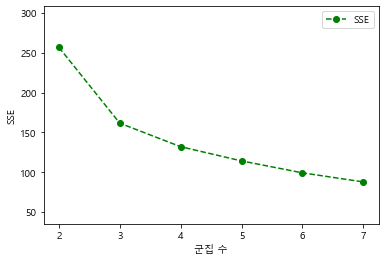

In [15]:
# 군집 수에 따른 SSE 시각화(best k = 3)
fig, ax = plt.subplots()
line = ax.plot(np.arange(2,8), wss, 'go--', label='SSE')
ax.set_ylim(wss.min()*0.4, wss.max()*1.2)
ax.set_xlabel('군집 수')
ax.set_ylabel('SSE')
labels = [l.get_label() for l in line]
plt.legend(line, labels)
plt.show() 

In [16]:
kmeans = KMeans(n_clusters=3, random_state=0, ) 
kmeans.fit(feature)

C:\Users\ha\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [17]:
feature['segment'] = kmeans.labels_

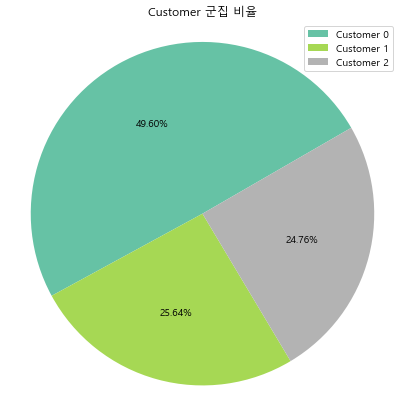

In [18]:
plt.figure(figsize=(7,7))
plt.pie(feature.segment.value_counts(), autopct='%.2f%%', startangle=30, colors=['#66c2a5', '#a6d854', '#b3b3b3'])
plt.title("Customer 군집 비율")
plt.axis('equal')
plt.legend(labels=['Customer 0', 'Customer 1', 'Customer 2'])
plt.show() 

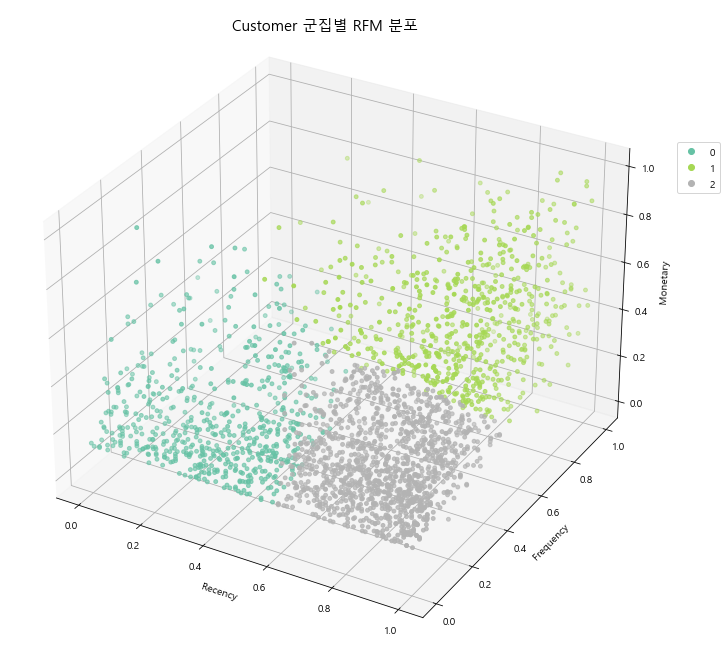

In [19]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
sc = ax.scatter3D(feature.recency, feature.frequency,feature.monetary, c=feature.segment, marker='o', s=15, cmap='Set2')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.text(-0.15, 1, 1.2, "Customer 군집별 RFM 분포", fontdict={'fontsize':15})
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.1, 0.8))
plt.show()

## Analyze Customer Features

#### $\bullet$ Column 생성

In [20]:
data['성별'] = data['성별'].apply(lambda x: '남성' if x==1 else '여성')
data['구매요일'] = data['구매일자'].dt.weekday.map(dict(zip(range(7), '월화수목금토일')))
data['여성상품'] = data['상품중분류명'].apply(lambda x: 1 if '여성' in x else 0)
data['남성상품'] = data['상품중분류명'].apply(lambda x: 1 if '남성' in x else 0)
data['단가'] = data['구매금액']/data['구매수량']

#### $\bullet$ 거래별로 집계하기

In [21]:
transcation = data[['ID','구매일자','구매지역']].drop_duplicates()\
              .sort_values(['ID','구매일자','구매지역']).set_index(['ID','구매일자','구매지역'])
transcation

Empty DataFrame
Columns: []
Index: [(741463, 2014-01-15 13:00:00, 서울 동대문구), (741463, 2014-02-08 15:00:00, 서울 동대문구), (741463, 2014-02-21 11:00:00, 서울 동대문구), (741463, 2014-03-05 14:00:00, 서울 동대문구), (741463, 2014-03-05 17:00:00, 서울 동대문구), (741463, 2014-03-06 13:00:00, 서울 동대문구), (741463, 2014-04-01 11:00:00, 서울 동대문구), (909249, 2014-01-18 13:00:00, 부산 중구), (909249, 2014-01-22 10:00:00, 부산 중구), (909249, 2014-02-10 13:00:00, 부산 해운대구), (909249, 2014-02-12 11:00:00, 부산 해운대구), (909249, 2014-02-15 15:00:00, 부산 해운대구), (909249, 2014-03-01 12:00:00, 부산 해운대구), (909249, 2014-03-01 15:00:00, 부산 해운대구), (909249, 2014-04-11 12:00:00, 부산 해운대구), (909249, 2014-04-11 13:00:00, 부산 해운대구), (909249, 2014-04-20 12:00:00, 부산 해운대구), (909249, 2014-04-20 14:00:00, 부산 해운대구), (909249, 2014-05-17 11:00:00, 부산 해운대구), (909249, 2014-05-18 11:00:00, 부산 해운대구), (909249, 2014-06-27 11:00:00, 부산 해운대구), (909249, 2014-06-27 13:00:00, 부산 해운대구), (909249, 2014-07-09 15:00:00, 부산 해운대구), (909249, 2014-07-11 11:00:00, 부산 해운대구), (909249, 2014-08-03 12:00:00, 부산 동래구), (909249, 2014-08-03 13:00:00, 부산 동래구), (909249, 2014-08-08 14:00:00, 부산 동래구), (909249, 2014-08-15 10:00:00, 부산 해운대구), (909249, 2014-12-13 17:00:00, 부산 해운대구), (909249, 2014-12-25 18:00:00, 부산 해운대구), (1065068, 2014-07-06 19:00:00, 서울 송파구), (1065068, 2014-10-10 17:00:00, 서울 동대문구), (1065068, 2014-10-10 20:00:00, 서울 동대문구), (1065068, 2014-12-22 19:00:00, 서울 동대문구), (1065068, 2014-12-29 11:00:00, 서울 성동구), (1310410, 2014-01-19 17:00:00, 경기 고양시), (1310410, 2014-10-12 12:00:00, 경기 고양시), (1387032, 2014-01-18 15:00:00, 서울 중구), (1387032, 2014-02-24 19:00:00, 경기 안양시), (1387032, 2014-11-19 13:00:00, 경기 안산시), (1387032, 2014-12-01 13:00:00, 서울 중구), (1529116, 2014-10-29 12:00:00, 서울 동대문구), (1529116, 2014-11-06 12:00:00, 서울 동대문구), (1529116, 2014-12-30 13:00:00, 서울 동대문구), (1639060, 2014-11-03 17:00:00, 경기 안양시), (1639060, 2014-12-28 13:00:00, 경기 안양시), (2272647, 2014-01-10 17:00:00, 부산 부산진구), (2272647, 2014-01-19 18:00:00, 부산 부산진구), (2272647, 2014-01-19 19:00:00, 부산 부산진구), (2272647, 2014-01-19 20:00:00, 부산 부산진구), (2272647, 2014-01-25 18:00:00, 부산 부산진구), (2272647, 2014-01-27 14:00:00, 부산 부산진구), (2272647, 2014-02-08 19:00:00, 부산 부산진구), (2272647, 2014-02-18 16:00:00, 부산 부산진구), (2272647, 2014-02-19 17:00:00, 부산 부산진구), (2272647, 2014-03-21 18:00:00, 부산 부산진구), (2272647, 2014-03-21 19:00:00, 부산 부산진구), (2272647, 2014-03-24 15:00:00, 부산 부산진구), (2272647, 2014-04-03 15:00:00, 부산 부산진구), (2272647, 2014-05-14 20:00:00, 부산 동래구), (2272647, 2014-06-06 17:00:00, 서울 중구), (2272647, 2014-06-30 17:00:00, 부산 부산진구), (2272647, 2014-06-30 19:00:00, 부산 부산진구), (2272647, 2014-08-20 18:00:00, 부산 부산진구), (2272647, 2014-08-20 19:00:00, 부산 부산진구), (2272647, 2014-09-03 20:00:00, 부산 부산진구), (2272647, 2014-09-04 15:00:00, 부산 부산진구), (2272647, 2014-09-06 20:00:00, 부산 해운대구), (2413953, 2014-01-11 17:00:00, 서울 강남구), (2413953, 2014-01-17 17:00:00, 서울 강남구), (2413953, 2014-01-26 18:00:00, 서울 강남구), (2413953, 2014-01-30 18:00:00, 서울 강남구), (2413953, 2014-02-02 14:00:00, 서울 강남구), (2413953, 2014-02-06 17:00:00, 서울 강남구), (2413953, 2014-02-12 19:00:00, 서울 강남구), (2413953, 2014-02-16 16:00:00, 서울 강남구), (2413953, 2014-02-26 15:00:00, 서울 강남구), (2413953, 2014-04-01 17:00:00, 경기 이천시), (2413953, 2014-05-05 15:00:00, 서울 강남구), (2413953, 2014-06-02 15:00:00, 서울 강남구), (2413953, 2014-06-13 17:00:00, 서울 강남구), (2413953, 2014-06-13 18:00:00, 서울 강남구), (2413953, 2014-06-25 17:00:00, 서울 강남구), (2413953, 2014-07-11 20:00:00, 서울 강남구), (2413953, 2014-07-12 12:00:00, 서울 강남구), (2413953, 2014-07-12 18:00:00, 서울 강남구), (2413953, 2014-07-17 12:00:00, 서울 송파구), (2413953, 2014-07-17 14:00:00, 서울 송파구), (2413953, 2014-07-19 12:00:00, 서울 강남구), (2413953, 2014-07-19 13:00:00, 서울 강남구), (2413953, 2014-08-28 19:00:00, 서울 강남구), (2413953, 2014-08-29 18:00:00, 서울 강남구), (2413953, 2014-09-04 17:00:00, 서울 강남구), (2413953, 2014-09-05 19:00:00, 서울 강남구), (2413953, 2014-09-06 17:00:00, 서울 강남구), (2413953, 2014-09-06 18:00:00, 서울 강남구), (2413953, 2014-09-09 11:00:00, 서울 강남구), (2413953, 2014-09-16 17:00:00, 서울 강남구), (2413953, 2014-09-25 11:00:0

In [22]:
# 하이마트에서 판매하는 가전제품, 생활잡화 외 품목을 구매한 거래를 백화점 거래라고 유추한다.
transcation['백화점구매'] = data.groupby(['ID','구매일자','구매지역'])['상품대분류명']\
                            .apply(lambda x: 1 if len(set(x) - set(['가전제품','생활잡화'])) != 0 else 0)

In [23]:
# 증정 행사를 이용한 거래를 구분한다.
transcation = pd.concat([transcation, 
                         data.query('취소여부==0 and 구매금액==0')\
                        .groupby(['ID','구매일자','구매지역'])['구매수량'].size().rename('행사이용수')], axis=1).fillna(0)

In [24]:
# 거래당 상품중분류명수, 구매수량, 구매금액, 단가 관련 정보를 생성한다.
ease = data.query('취소여부==0').groupby(['ID','구매일자','구매지역'])\
       .agg({'상품중분류명':pd.Series.nunique, '거주지역':np.size, 
             '구매수량': [sum, max, min], '구매금액': [sum, max, min], '단가': [max, min]})
ease.columns = ['상품종류수','상품수','총구매수량','최대구매수량','최소구매수량',
                '총구매금액','최대구매금액','최소구매금액','최대단가','최소단가']
transcation = pd.concat([transcation, ease], axis=1).fillna(0)

In [25]:
# 취소거래당 상품중분류명수, 구매수량, 구매금액, 단가 관련 정보를 생성한다.
ease = data.query('취소여부==1').groupby(['ID','구매일자','구매지역'])\
       .agg({'상품중분류명':pd.Series.nunique, '거주지역':np.size, 
             '구매수량': [sum, max, min], '구매금액': [sum, max, min], '단가': [max, min]})
ease.iloc[:,-8:-2] = ease.iloc[:,-8:-2] * -1
ease.columns = [f'취소{i}' for i in transcation.columns[-10:]]
transcation = pd.concat([transcation, ease], axis=1).fillna(0)

In [26]:
transcation.reset_index(inplace=True)
transcation

,ID,구매일자,구매지역,백화점구매,행사이용수,상품종류수,상품수,총구매수량,최대구매수량,최소구매수량,...,취소상품종류수,취소상품수,취소총구매수량,취소최대구매수량,취소최소구매수량,취소총구매금액,취소최대구매금액,취소최소구매금액,취소최대단가,취소최소단가
0,741463,2014-01-15 13:00:00,서울 동대문구,1,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,741463,2014-02-08 15:00:00,서울 동대문구,1,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,741463,2014-02-21 11:00:00,서울 동대문구,1,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,741463,2014-03-05 14:00:00,서울 동대문구,1,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,741463,2014-03-05 17:00:00,서울 동대문구,1,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52854,999375162,2014-12-20 14:00:00,서울 강남구,1,0.0,2.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52855,999375162,2014-12-21 13:00:00,서울 강남구,1,0.0,2.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52856,999494396,2014-06-26 11:00:00,서울 송파구,1,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52857,999494396,2014-06-27 15:00:00,서울 송파구,1,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### $\bullet$ Feature 생성

In [60]:
feature[['백화점이용수','백화점이용률']] = transcation.groupby('ID')['백화점구매'].agg([sum, np.mean])
feature.shape

(3537, 46)

In [61]:
ease = transcation.query('백화점구매==0').groupby('ID')[['행사이용수', '상품종류수', '상품수', 
                                                        '총구매수량', '최대구매수량', '최소구매수량', 
                                                        '총구매금액', '최대구매금액', '최소구매금액',
                                                        '취소상품종류수', '취소상품수', 
                                                        '취소총구매수량', '취소최대구매수량', '취소최소구매수량', 
                                                        '취소총구매금액', '취소최대구매금액', '취소최소구매금액']].mean()
ease.columns = [f'하이마트_평균{i}' for i in ease.columns]
ease = pd.concat([ease, 
                  transcation.query('백화점구매==0').groupby('ID')[['총구매수량', '총구매금액', '취소총구매수량', '취소총구매금액']].sum()], axis=1)
ease.columns = ease.columns.tolist()[:-4] + [f'하이마트_{i}' for i in ease.columns[-4:]]
feature = pd.concat([feature, ease], axis=1).fillna(0)
feature.shape

(3537, 66)

In [62]:
ease = transcation.query('백화점구매==1').groupby('ID')[['행사이용수', '상품종류수', '상품수', 
                                                        '총구매수량', '최대구매수량', '최소구매수량', 
                                                        '총구매금액', '최대구매금액', '최소구매금액',
                                                        '취소상품종류수', '취소상품수', 
                                                        '취소총구매수량', '취소최대구매수량', '취소최소구매수량', 
                                                        '취소총구매금액', '취소최대구매금액', '취소최소구매금액']].mean()
ease.columns = [f'백화점_평균{i}' for i in ease.columns]
ease = pd.concat([ease, 
                  transcation.query('백화점구매==1').groupby('ID')[['총구매수량', '총구매금액', '취소총구매수량', '취소총구매금액']].sum()], axis=1)
ease.columns = ease.columns.tolist()[:-4] + [f'백화점_{i}' for i in ease.columns[-4:]]
feature = pd.concat([feature, ease], axis=1).fillna(0)
feature.shape

(3537, 86)